# 2.2.2 Ensemble Learning
#### CS 6350: HW 2

---

[36 points] We will implement the boosting and bagging algorithms based on decision
trees. Let us test them on the bank marketing dataset in HW1 (bank.zip in Canvas).
We use the same approach to convert the numerical features into binary ones. That
is, we choose the media (NOT the average) of the attribute values (in the training set)
as the threshold, and examine if the feature is bigger (or less) than the threshold. For
simplicity, we treat “unknown” as a particular attribute value, and hence we do not
have any missing attributes for both training and test.

In [1]:
from decision_tree import *

In [2]:
from tqdm import tqdm

In [43]:
import pprint

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
test_data = pd.read_csv('bank/test.csv', header=None)
train_data = pd.read_csv('bank/train.csv', header=None)

In [6]:
data = train_data

In [7]:
columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

train_data.columns = columns
test_data.columns = columns

In [8]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,41,services,married,secondary,no,0,yes,no,unknown,5,may,114,2,-1,0,unknown,no
1,48,blue-collar,single,secondary,no,312,yes,yes,cellular,3,feb,369,2,-1,0,unknown,no
2,55,technician,married,secondary,no,1938,no,yes,cellular,18,aug,193,1,386,3,success,yes
3,54,admin.,married,tertiary,no,59,yes,no,cellular,10,jul,268,1,-1,0,unknown,no
4,34,management,single,tertiary,no,2646,no,no,cellular,14,apr,142,1,-1,0,unknown,yes


In [9]:
num_2_binary(train_data)
num_2_binary(test_data)

In [10]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True,unknown,no
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True,unknown,no
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True,success,yes
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True,unknown,no
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True,unknown,yes


In [11]:
test_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,True,management,single,secondary,no,True,no,no,cellular,False,jun,True,True,True,True,unknown,no
1,True,blue-collar,married,secondary,no,False,yes,no,cellular,False,may,True,False,True,True,failure,no
2,True,retired,married,primary,no,False,no,no,telephone,True,jul,False,True,True,True,unknown,no
3,False,entrepreneur,single,tertiary,no,False,yes,yes,unknown,False,jun,True,False,True,True,unknown,no
4,False,student,single,unknown,no,True,no,no,telephone,True,jan,False,True,True,True,unknown,no


---

### A. decision stumps

[8 points] Modify your decision tree learning algorithm to learn decision stumps
— trees with only two levels. Specifically, compute the information gain to select
the best feature to split the data. Then for each subset, create a leaf node. Note
that your decision stumps must support weighted training examples. Based on
your decision stump learning algorithm, implement AdaBoost algorithm. Vary
the number of iterations T from 1 to 1000, and examine the training and test
errors. You should report the results in two figures. The first figure shows how the
training and test errors vary along with T. The second figure shows the training
and test errors of all the decision stumps learned in each iteration. What can you
observe and conclude? You have had the results for a fully expanded decision tree
in HW1. Comparing them with Adaboost, what can you observe and conclude?

In [ ]:
def ada_boost(train_data, test_data, max_iter=5):
    
    # keep track of alphas and hypotheses
    alphas = []
    trees = []
    
    attrs = list(train_data.columns.values)[:-1]
    label = list(train_data.columns.values)[-1]
    
    M_train,N_train = train_data.shape
    M_test, N_test = test_data.shape
    
    # initialize weights, D_1
    weights = np.ones(M_train)/M_train
    
    # initialize hypotheses, one each for training and testing data
    h_train = np.zeros(M_train)
    h_test = np.zeros(M_test)
    
    
    for t in tqdm(range(max_iter)):
        print('')
        print('iter: {}'.format(t))
        # Train weak learner using training data weighted according to D_t
        tree = id3(train_data, train_data, attrs, label, gain_method=entropy, parent_label=None, weights=weights, current_depth=0, max_depth=2)
        # get weak hypothesis
        h = weak_hypothesis(tree, train_data)
        h_t = np.array(list(map(lambda x: 1 if x else -1, h)))
        
        # convert "yes" and "no" to 1 and -1 respectively in 'y' column
        y = np.array(list(map(lambda x: 1 if x=='yes' else -1, train_data['y'].tolist())))
        
        # calculate error w.r.t. D_t
        error_t = np.sum((h_t != y) * weights)
        print('error check: {}'.format(error_t))
        
        if error_t > 0.5:
            invert = -1
            error_t = 1 - error_t
            #weights = - weights
            #tree = id3(train_data, train_data, attrs, label, gain_method=entropy, parent_label=None, weights=weights, current_depth=0, max_depth=2)
            #h = weak_hypothesis(tree, train_data)
            #h_t = np.array(list(map(lambda x: 1 if x else -1, h)))
            #error_t = np.sum((h_t != y) * weights)
        else:
            invert = 1
        
        # get alpha
        alpha_t = 0.5*invert*np.log((1-error_t)/float(error_t))
        
        print('error {}: {}'.format(t,error_t))
        print('alpha {}: {}'.format(t,alpha_t))
        
        alphas.append(alpha_t)
        trees.append(tree)
        
        # update weights
        weights = weights*np.exp(-alpha_t*y*h_t)
        weights = weights / np.sum(weights)
        
        #print('weights {}: {}'.format(t,weights))
        #print('weight avg: {}'.format(np.mean(weights)))

    # final classifier is summation of alphas and hypotheses
    #H = np.sign(np.sum(np.array(alphas)*np.array(hypos), axis=1))
    
    return alphas, trees

In [12]:
def weak_hypothesis(tree, data):
    N = data.shape[0]
    h = np.zeros(N)
    
    for i in range(N):
        h[i] = predict_label(data.iloc[i],tree,'y')
    
    return h

In [13]:
def evaluate_ada(alphas, trees, train_data, test_data):
    
    train_error = []
    test_error = []
    
    n_train = train_data.shape[0]
    n_test = test_data.shape[0]
    
    max_iter = len(alphas)
    
    for t in tqdm(range(max_iter)):
        train_sum = np.zeros(n_train)
        test_sum = np.zeros(n_test)
        
        for i in range(t):
            a_t = alphas[i]
            tree = trees[i]
            h_train = np.array(list(map(lambda x: 1 if x else -1, weak_hypothesis(tree, train_data))))
            h_test = np.array(list(map(lambda x: 1 if x else -1, weak_hypothesis(tree, test_data))))
            train_sum += (a_t*h_train)
            test_sum += (a_t*h_test)
            
        #print('t={}'.format(t))
        #print('train_sum: {}'.format(train_sum))
        #print('train_sum avg: {}'.format(np.mean(train_sum)))
        #print('test_sum: {}'.format(test_sum))
            
        train_final = np.sign(train_sum)
        test_final = np.sign(test_sum)
        
        #print('train_final: {}'.format(train_final))
        #print('train_final avg: {}'.format(np.mean(train_final)))
        #print('test_final avg: {}'.format(np.mean(test_final)))
        
        y_train = np.array(list(map(lambda x: 1 if x=='yes' else -1, train_data['y'].tolist())))
        y_test = np.array(list(map(lambda x: 1 if x=='yes' else -1, test_data['y'].tolist())))
        
        train_error.append(np.sum(train_final != y_train)/n_train)
        test_error.append(np.sum(test_final != y_test)/n_test)
        
    return train_error, test_error
            

In [57]:
np.median([1,2,3.5])

2.0

In [ ]:
a = np.zeros(10)
a += 1
a

In [24]:
weights = np.ones(10)/10

In [25]:
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [59]:
h = np.array([1,1,1,1,1,0,0,0,0,0])
y = np.array([1,1,1,0,0,0,0,0,0,0])

In [61]:
np.median([h,y], axis=0)

array([1. , 1. , 1. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ])

In [33]:
np.sum(weights[h>0])

0.5

In [ ]:
alphas, trees = ada_boost(train_data, test_data, max_iter=10)

In [19]:
len(alphas)

100

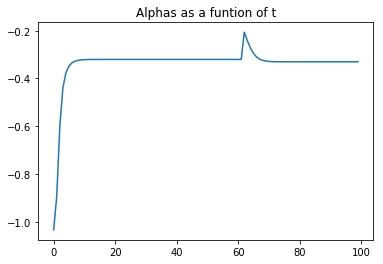

In [20]:
plt.figure()
plt.plot(range(100), alphas)
plt.title("Alphas as a funtion of t")
plt.show()

In [ ]:
plt.figure()
plt.plot(range(1,1501), training_error, label="Training error")
plt.plot(range(1,1501), testing_error, label="Testing error")
plt.title("Training and Testing error of fboost(t) for t = 1, 2, ... 1500")
plt.legend()
plt.show()

---

### B. Bagged Trees

[8 points] Based on your code of the decision tree learning algorithm (with information gain), implement a Bagged trees learning algorithm. Note that each tree
should be fully expanded — no early stopping or post pruning. Vary the number
of trees from 1 to 1000, report how the training and test errors vary along with
the tree number in a figure. Overall, are bagged trees better than a single tree?
Are bagged trees better than Adaboost?


In [19]:
from decision_tree import *

In [62]:
def bagging(train_data, test_data, n_samples=1000, max_iter=10):
    
    M_train,N_train = train_data.shape
    M_test, N_test = test_data.shape
    
    attrs = list(train_data.columns.values)[:-1]
    label = list(train_data.columns.values)[-1]
    
    trees = []
    predictions = []
    
    for t in tqdm(range(max_iter)):
        #print('')
        #print('iter: ' + str(t))
        sample = train_data.sample(n_samples, replace=True)
        
        tree = id3(sample, sample, attrs, label, gain_method=entropy,
                   parent_label=None, current_depth=0, max_depth=100)
        trees.append(tree)
        
        h_t = np.array(list(map(lambda x: 1 if x else -1, weak_hypothesis(tree, train_data))))
        predictions.append(h_t)
        
    
    # take average of predictions
    H = np.median(predictions, axis=0)
    
    return H

In [51]:
def eval_bag(H, data):
    n = train_data.shape[0]
    y = np.array(list(map(lambda x: 1 if x=='yes' else -1, data['y'].tolist())))
    
    return np.sum(H != y)/n

In [30]:
attrs = list(train_data.columns.values)[:-1]
label = list(train_data.columns.values)[-1]

In [28]:
sample = train_data.sample(1000, replace=True)
sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2804,False,services,married,secondary,no,False,no,no,unknown,True,may,False,False,True,True,unknown,no
1549,True,blue-collar,married,primary,no,True,yes,no,cellular,False,may,True,True,True,True,other,no
2547,False,admin.,married,secondary,yes,False,no,yes,cellular,False,feb,False,True,True,True,unknown,no
3595,True,services,married,secondary,no,True,no,no,cellular,True,aug,True,True,True,True,unknown,no
3100,False,technician,single,secondary,no,False,yes,yes,unknown,True,may,False,True,True,True,unknown,no


In [38]:
h_t = np.array(list(map(lambda x: 1 if x else -1, weak_hypothesis(tree, train_data))))
h_t[:20]

array([ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1])

In [45]:
y_train = np.array(list(map(lambda x: 1 if x=='yes' else -1, train_data['y'].tolist())))
y_train[:20]

array([-1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1])

AttributeError: module 'numpy' has no attribute 'mode'

In [63]:
H = bagging(train_data, test_data, n_samples=1000, max_iter=2)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 11.83s/it]


In [64]:
eval_bag(H, train_data)

0.9642

In [65]:
H2 = bagging(train_data, test_data, n_samples=1000, max_iter=3)
eval_bag(H2,train_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.70s/it]


0.9346

In [66]:
H3 = bagging(train_data, test_data, n_samples=1000, max_iter=4)
eval_bag(H3,train_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.91s/it]


0.9572

In [67]:
H4 = bagging(train_data, test_data, n_samples=1000, max_iter=5)
eval_bag(H4,train_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.43s/it]


0.9432

In [21]:
train_final = np.sign(H)
train_final

array([ 1.,  1., -1., ...,  1.,  1.,  1.])

In [25]:
train_final[0:20]

array([ 1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [17]:
y_train = np.array(list(map(lambda x: 1 if x=='yes' else -1, train_data['y'].tolist())))
y_train

array([-1, -1,  1, ..., -1, -1, -1])

In [19]:
n_train = train_data.shape[0]
n_train

5000

In [47]:
np.sum(train_final != y_train)/n_train

0.9674

In [94]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True,unknown,no
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True,unknown,no
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True,success,yes
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True,unknown,no
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True,unknown,yes


In [104]:
list(np.unique(data['month']))

['apr',
 'aug',
 'dec',
 'feb',
 'jan',
 'jul',
 'jun',
 'mar',
 'may',
 'nov',
 'oct',
 'sep']

In [105]:
attr_dict = {}

for col in data:
    attr_dict[col] = list(np.unique(data[col]))

In [106]:
attr_dict

{'age': [False, True],
 'job': ['admin.',
  'blue-collar',
  'entrepreneur',
  'housemaid',
  'management',
  'retired',
  'self-employed',
  'services',
  'student',
  'technician',
  'unemployed',
  'unknown'],
 'marital': ['divorced', 'married', 'single'],
 'education': ['primary', 'secondary', 'tertiary', 'unknown'],
 'default': ['no', 'yes'],
 'balance': [False, True],
 'housing': ['no', 'yes'],
 'loan': ['no', 'yes'],
 'contact': ['cellular', 'telephone', 'unknown'],
 'day': [False, True],
 'month': ['apr',
  'aug',
  'dec',
  'feb',
  'jan',
  'jul',
  'jun',
  'mar',
  'may',
  'nov',
  'oct',
  'sep'],
 'duration': [False, True],
 'campaign': [False, True],
 'pdays': [True],
 'previous': [True],
 'poutcome': ['failure', 'other', 'success', 'unknown'],
 'y': ['no', 'yes']}

In [107]:
attr_d = {'age': [False, True],
 'job': ['admin.',
  'blue-collar',
  'entrepreneur',
  'housemaid',
  'management',
  'retired',
  'self-employed',
  'services',
  'student',
  'technician',
  'unemployed',
  'unknown'],
 'marital': ['divorced', 'married', 'single'],
 'education': ['primary', 'secondary', 'tertiary', 'unknown'],
 'default': ['no', 'yes'],
 'balance': [False, True],
 'housing': ['no', 'yes'],
 'loan': ['no', 'yes'],
 'contact': ['cellular', 'telephone', 'unknown'],
 'day': [False, True],
 'month': ['apr',
  'aug',
  'dec',
  'feb',
  'jan',
  'jul',
  'jun',
  'mar',
  'may',
  'nov',
  'oct',
  'sep'],
 'duration': [False, True],
 'campaign': [False, True],
 'pdays': [True],
 'previous': [True],
 'poutcome': ['failure', 'other', 'success', 'unknown'],
 'y': ['no', 'yes']}

---

### C. Optimal weight vector with analytical form

Through the bias and variance decomposition, we have justified why
the bagging approach is more effective than a single classifier/predictor. Let us
verify it in real data. Experiment with the following procedure.

• REPEAT for 100 times

• [STEP 1] Sample 1, 000 examples uniformly without replacement from the training datset

• [STEP 2] Run your bagged trees learning algorithm based on the 1, 000 training examples and learn 1000 trees.

• END REPEAT


• Now you have 100 bagged predictors in hand. For comparison, pick the first
tree in each run to get 100 fully expanded trees (i.e. single trees).


• For each of the test example, compute the predictions of the 100 single trees.
Take the average, subtract the ground-truth label, and take square to compute
the bias term (see the lecture slides). Use all the predictions to compute the
sample variance as the approximation to the variance term (if you forget
what the sample variance is, check it out here). You now obtain the bias and
variance terms of a single tree learner for one test example. You will need
to compute them for all the test examples and then take average as your
final estimation of the bias and variance terms for the single decision tree
learner. You can add the two terms to obtain the estimation of the general
squared error (that is, expected error w.r.t test examples). Now use your 100
bagged predictors to do the same thing and estimate the general bias and
variance terms, as well as the general squared error. Comparing the results
of the single tree learner and the bagged trees, what can you conclude? What
causes the difference?


---

### D. Random Forest

 [8 points] Implement the random forest algorithm as we discussed in our lecture.
Vary the number of random trees from 1 to 1000. Note that you need to modify
your tree learning algorithm to randomly select a subset of features before each
split. Then use the information gain to select the best feature to split. Vary the
size of the feature subset from {2, 4, 6}. Note that if your feature subset happen
to be all the features used before, simply resample the subset. Report in a figure
how the training and test errors vary along with the number of random trees for
each feature subset size setting. How does the performance compare with bagged
trees?

In [84]:
def random_forest(train_data, test_data, max_iter=10):
    
    M_train,N_train = train_data.shape
    M_test, N_test = test_data.shape
    
    attrs = list(train_data.columns.values)[:-1]
    label = list(train_data.columns.values)[-1]
    
    trees = []
    predictions = []
    
    for t in tqdm(range(max_iter)):
        #print('')
        #print('iter: ' + str(t))
        sample = train_data.sample(M_train, replace=True)
        
        tree = rand_tree_learn(sample, sample, attrs, label, gain_method=entropy, parent_label=None)
        
        #tree = id3(sample, sample, attrs, label, gain_method=entropy,
        #           parent_label=None, current_depth=0, max_depth=100)
        #trees.append(tree)
        
        h_t = np.array(list(map(lambda x: 1 if x else -1, weak_hypothesis(tree, train_data))))
        predictions.append(h_t)
        
    
    # take average of predictions
    H = np.median(predictions, axis=0)
    
    return H

In [87]:
def rand_tree_learn(data, original_data, attrs, target_attr, gain_method, parent_label, current_depth=0, max_depth=100):
    """ ID3 Algorithm

    Args:
        data (pandas dataframe): input data
        original_data (pandas dataframe): copy of original, untouched data 
        attrs (list): list of strings of attributes, all but the target attribute
        target_attr (str): name of attribute to be used at the target labels
        gain_method (function name): Information Gain method, either entropy, maj_error, or gini
        parent_label (int): attribute label of parent node in recursive algorithm.
        current_depth (int): current tree depth
        max_depth (int): maximum tree depth

    Returns:
        tree (dict): dictionary structure represented the decision tree

    """
    
    M,N = data.shape

    # if all target labels are the same, stop and return this value
    unique_labels = np.unique(data[target_attr])
    if len(unique_labels) == 1:
        #
        return unique_labels[0]

    # if the data is empty, return the label that occurs the most in the origional data
    elif len(data) == 0:
        vals, freqs = np.unique(original_data[target_attr], return_counts=True)
        return vals[np.argmax(freqs)]

    # if there are no more attributes, return the parent label
    elif len(attrs) == 0:
        return parent_label
    else:
        current_depth += 1
        # set value for this node to the mode of the target feature values
        vals, freqs = np.unique(data[target_attr], return_counts=True)
        parent_label = vals[np.argmax(freqs)]

        # if max depth is reached, return label that occurs the most
        if current_depth == max_depth+1:
            return parent_label
        
        # Randomly sample subset of Features
        features = data.iloc[:,:N-1]
        # feature subset g random features, where g is square root of number of features
        G_count = int(np.floor(np.sqrt(N-1)))
        # subset of features
        subdata = features.sample(G_count, axis=1)
        subdata['y'] = data.iloc[:,-1]
        
        subattrs = list(subdata.columns.values)[:-1]

        # Find best attribute to split data on using Subdata
        info_gains = [info_gain(subdata, attr, target_attr, gain_method)
                      for attr in subattrs]
        best_attr = attrs[info_gains.index(max(info_gains))]

        # create new subtree
        tree = dict()
        tree[best_attr] = dict()

        # remove best attribute from attribute list
        attrs = [i for i in attrs if i != best_attr]

        # grow tree
        for val in np.unique(original_data[best_attr]):
            val = val
            new_data = dict(data)

            # split dataset on the best attribute and remove this column from dataset
            new_data = data.where(data[best_attr] == val).dropna()

            # Recursion
            new_tree = id3(new_data, original_data, attrs, target_attr,
                           gain_method, parent_label, current_depth, max_depth)

            # Add subtree to parents tree
            tree[best_attr][val] = new_tree

        return tree

In [88]:
H = random_forest(train_data, test_data, max_iter=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:05<00:00, 42.54s/it]


In [89]:
eval_bag(H,train_data)

0.905

In [91]:
H[:20]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.])

In [93]:
y_train[:20]

array([-1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1])

In [76]:
M,N = data.shape

In [79]:
data.iloc[:,:N-1].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True,unknown
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True,unknown
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True,success
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True,unknown
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True,unknown


In [80]:
features = data.iloc[:,:N-2]
features.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True


In [81]:
features['AAA'] = data.iloc[:,-1]

features.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,AAA
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True,no
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True,no
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True,yes
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True,no
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True,yes


In [68]:
M,N = train_data.shape
M,N

(5000, 17)

In [69]:
data = train_data

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,True,services,married,secondary,no,False,yes,no,unknown,False,may,False,True,True,True,unknown,no
1,True,blue-collar,single,secondary,no,False,yes,yes,cellular,False,feb,True,True,True,True,unknown,no
2,True,technician,married,secondary,no,True,no,yes,cellular,True,aug,True,False,True,True,success,yes
3,True,admin.,married,tertiary,no,False,yes,no,cellular,False,jul,True,False,True,True,unknown,no
4,False,management,single,tertiary,no,True,no,no,cellular,False,apr,False,False,True,True,unknown,yes


In [70]:
data.sample(2, axis=1)

,education,marital
0,secondary,married
1,secondary,single
2,secondary,married
3,tertiary,married
4,tertiary,single
5,secondary,divorced
6,secondary,married
7,secondary,single
8,primary,married
9,tertiary,married


---

### E. Single random tree vs whole forest

[6 points] Following (c), estimate the bias and variance terms, and the squared
error for a single random tree and the whole forest. Comparing with the bagged
trees, what do you observe? What can you conclude?

In [27]:
test_tree = {'duration': {False: {'month': {'apr': 'no',
    'aug': 'no',
    'dec': 'no',
    'feb': 'no',
    'jan': 'no',
    'jul': 'no',
    'jun': 'no',
    'mar': 'no',
    'may': 'no',
    'nov': 'no',
    'oct': 'no',
    'sep': 'no'}},
  True: {'poutcome': {'failure': 'no',
    'other': 'no',
    'success': 'yes',
    'unknown': 'no'}}}}